In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [20]:

import pathlib

data_dir = tf.keras.utils.get_file(  os.path.join( os.getcwd(),"dataset"),  origin=os.path.join( os.getcwd()), untar=False)
data_dir = pathlib.Path(data_dir)

print(data_dir)

c:\Users\jairxx20\Documents\Universidad\2021-01\Inteligencia Artificial\TF-IA-202101\backend\dataset


In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

307


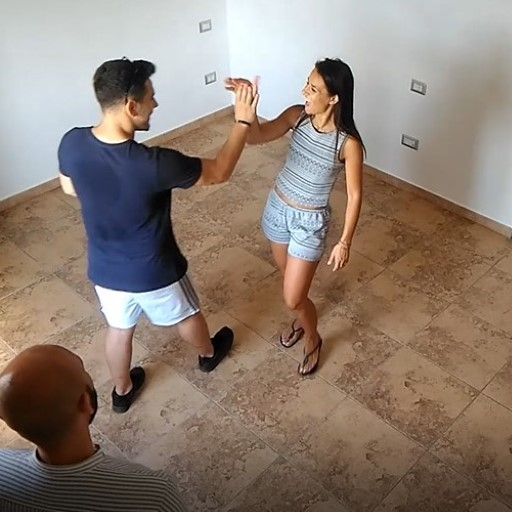

In [22]:
roses = list(data_dir.glob('no-violenta/*'))
PIL.Image.open(str(roses[2]))

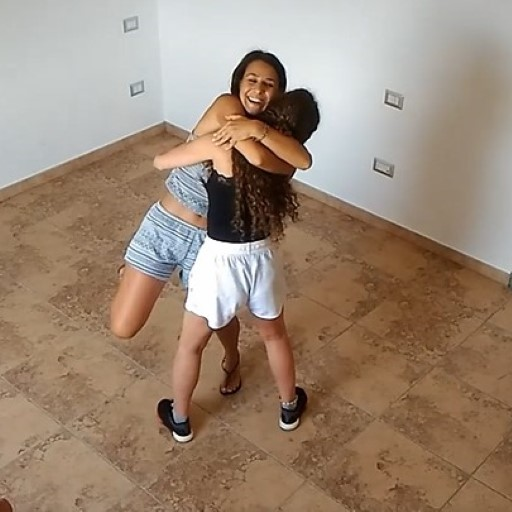

In [23]:
PIL.Image.open(str(roses[1]))


In [40]:

# Load using keras.preprocessing
# Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the load images tutorial.

# Create a dataset
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [41]:
# It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 307 files belonging to 2 classes.
Using 246 files for training.


In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 307 files belonging to 2 classes.
Using 61 files for validation.


In [43]:

class_names = train_ds.class_names
print(class_names)

['no-violenta', 'violenta']


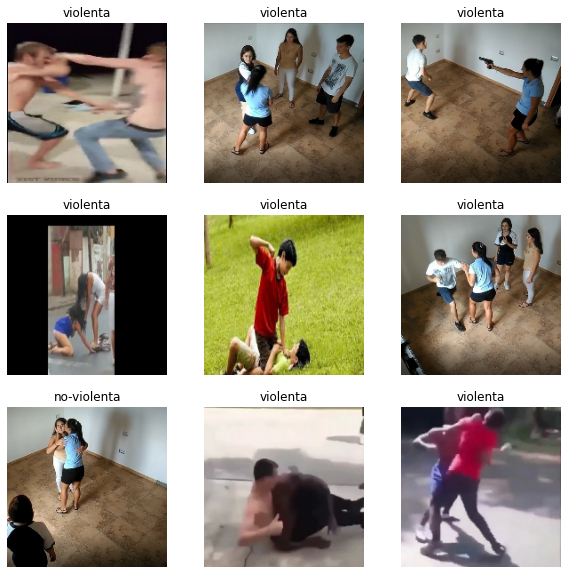

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [48]:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [49]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [50]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [58]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
8/8 [==============================] - 6s 815ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.7672 - val_accuracy: 0.8689
Epoch 2/100
8/8 [==============================] - 7s 839ms/step - loss: 0.0318 - accuracy: 0.9878 - val_loss: 0.7586 - val_accuracy: 0.9016
Epoch 3/100
8/8 [==============================] - 7s 920ms/step - loss: 0.0277 - accuracy: 0.9878 - val_loss: 0.8739 - val_accuracy: 0.8525
Epoch 4/100
8/8 [==============================] - 7s 898ms/step - loss: 0.0567 - accuracy: 0.9837 - val_loss: 0.8493 - val_accuracy: 0.8852
Epoch 5/100
8/8 [==============================] - 6s 779ms/step - loss: 0.0332 - accuracy: 0.9878 - val_loss: 0.6396 - val_accuracy: 0.9016
Epoch 6/100
8/8 [==============================] - 6s 798ms/step - loss: 0.0363 - accuracy: 0.9837 - val_loss: 0.7768 - val_accuracy: 0.9180
Epoch 7/100
8/8 [==============================] - 6s 746ms/step - loss: 0.0302 - accuracy: 0.9919 - val_loss: 0.7884 - val_accuracy: 0.8852
Epoch 8/100
8

In [59]:
def prediction():
    
    img = keras.preprocessing.image.load_img(
        os.path.join(os.getcwd(), "test1.jpg"), target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    return {"label": format(class_names[np.argmax(score)]), "percentage": 100 * np.max(score)}

In [60]:
from flask import Flask
from flask import jsonify
from flask import request
from flask_cors import CORS
import os


In [56]:
app = Flask(__name__)
CORS(app)


UPLOAD_FOLDER = os.getcwd()
ALLOWED_EXTENSIONS = {'txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'}


def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # check if the post request has the file part
        if 'file' not in request.files:
             return jsonify({"error": "no hay"})
        file = request.files['file']
        # If the user does not select a file, the browser submits an
        # empty file without a filename.
        if file.filename == '':
            return jsonify({"error": "no hay"})

        if file and allowed_file(file.filename):
            filename = file.filename
            file.save(os.path.join(UPLOAD_FOLDER, filename))
            return jsonify(prediction())

app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Jun/2021 08:44:55] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.00 percent confidence.
127.0.0.1 - - [25/Jun/2021 08:45:09] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.00 percent confidence.
127.0.0.1 - - [25/Jun/2021 08:45:14] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.00 percent confidence.
127.0.0.1 - - [25/Jun/2021 08:45:19] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.00 percent confidence.
127.0.0.1 - - [25/Jun/2021 08:45:25] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.00 percent confidence.
127.0.0.1 - - [25/Jun/2021 08:45:30] "POST / HTTP/1.1" 200 -
This image most likely belongs to violenta with a 100.0